### SHAP: интерпретация результатов

1. набор данных для бинарной классификации
2. feature engineering
3. обучение классификатора
4. feature_importances_
5. SHAP:
    - summary_plot для всего тестового набора данных
    - force_plot для отдельных наблюдений force_plot


In [ ]:
#!pip install shap

In [ ]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost

import matplotlib.pyplot as plt
%matplotlib inline

import shap
shap.initjs()

### 1. Загрузка данных

Датасет содержит анонимные данные о 395 студентах двух средних школ в Португалии.

Таргет: по умолчанию в соревновании на kaggle это успеваемость по математике или португальскому (G1-G3).

У меня: *paid*, дополнительные курсы по предмету (в моем случае только по математике).

In [ ]:
data = pd.read_csv('/content/Maths.csv')

In [ ]:
info = pd.read_excel('/content/info.xlsx')
info
# G3 = final math grade (numeric: from 0 to 20, output target)

,Columns,Description
0,school,student's school (binary: 'GP' - Gabriel Perei...
1,sex,student's sex (binary: 'F' - female or 'M' - m...
2,age,student's age (numeric: from 15 to 22)
3,address,student's home address type (binary: 'U' - urb...
4,famsize,family size (binary: 'LE3' - less or equal to ...
5,Pstatus,parent's cohabitation status (binary: 'T' - li...
6,Medu,"mother's education (numeric: 0 - none, 1 - pri..."
7,Fedu,"father's education (numeric: 0 - none, 1 - pri..."
8,Mjob,"mother's job (nominal: 'teacher', 'health' car..."
9,Fjob,"father's job (nominal: 'teacher', 'health' car..."


In [ ]:
data['health'].value_counts()

5    146
3     91
4     66
1     47
2     45
Name: health, dtype: int64

In [ ]:
len(data.columns)

33

In [ ]:
target = 'paid'

data[target] = data[target].replace({'yes': 1, 'no': 0})

data[target].value_counts(normalize=True)

0    0.541772
1    0.458228
Name: paid, dtype: float64

In [ ]:
data.drop(target, axis=1).corrwith(data[target])*100

age           -3.593287
Medu          15.970038
Fedu           8.698142
traveltime    -6.642024
studytime     16.721988
failures     -18.803897
famrel         0.045965
freetime      -6.425287
goout          1.049327
Dalc           6.246536
Walc           6.045364
health        -7.813240
absences       0.743517
G1             3.907932
G2            10.519841
G3            10.199624
dtype: float64

In [ ]:
cat_features = data.select_dtypes('object').columns.to_list()

num_features = data.drop(target, axis=1).select_dtypes(['int64', 'float64']).columns.to_list()

print(cat_features)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'activities', 'nursery', 'higher', 'internet', 'romantic']


### 2. Feature engineering

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


In [ ]:
cat_feats = Pipeline(steps=[
                ('selector', ColumnSelector(key=cat_features)),
                ('ohe', OHEEncoder(key=cat_features))
            ])

In [ ]:
num_feats = Pipeline(steps=[
                ('selector', ColumnSelector(key=num_features)),
                ('standard', StandardScaler())
            ])

In [ ]:
feats = FeatureUnion([('numeric_features', num_feats),
                      ('cat_features', cat_feats)
                      ])

### 3. Обучение классификатора

In [ ]:
y = data[target]
X = data.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=197)

In [ ]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state = 197)),
])

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
preds = classifier.predict_proba(X_test)[:, 1]

In [ ]:
preds[:10]

array([0.78, 0.53, 0.23, 0.57, 0.29, 0.1 , 0.28, 0.53, 0.67, 0.65])

In [ ]:
def show_metrics(y_test, preds):

  precision, recall, thresholds = precision_recall_curve(y_test, preds)
  fscore = (2*precision * recall) / (precision + recall)
  ix = np.argmax(fscore)
    
  print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix],
                                                                          precision[ix], recall[ix]))
  

show_metrics(y_test, preds)

Best Threshold=0.420000, F-Score=0.767, Precision=0.708, Recall=0.836


### 4. Feature_importances_

In [ ]:
# важность признаков меня интересует в первую очередь численных
num_classifier = Pipeline([
    ('features', num_feats),
    ('classifier', RandomForestClassifier(random_state = 197)),
])

num_classifier.fit(X_train[num_features], y_train)

In [ ]:
num_importances = pd.DataFrame(num_classifier[1].feature_importances_, 
                        num_features, 
                        columns=['coefs'])

num_importances.sort_values(by='coefs', ascending=False).head(5)

,coefs
G2,0.097530
G1,0.094126
G3,0.085641
absences,0.081606
health,0.071576


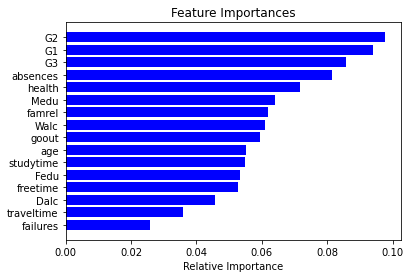

In [ ]:
importances = num_classifier[1].feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [num_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Видно, что на результаты экзаменов в большей степени влияют понятные признаки: успеваемость по семестрам, посещаемость, здоровье, обстановка дома.

Посмотрим, что покажет SHAP-анализ.

### 5. SHAP

In [ ]:
# для удобства я снова оставляю только непрерывные признаки
# и обучаю xgboost
model = xgboost.train({"learning_rate": 0.01}, 
                   xgboost.DMatrix(X_train[num_features], label=y_train), 100)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[num_features])

*summary_plot*

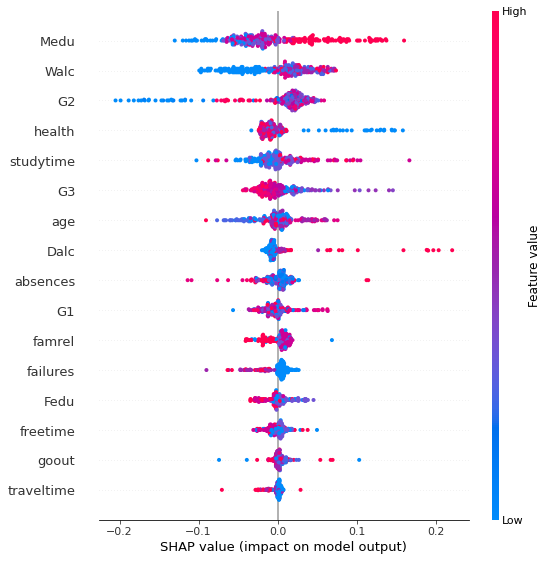

In [ ]:
shap.summary_plot(shap_values, X_train[num_features])

*summary_plot* показывает вклад каждого признака в предсказание модели относительно среднего прогноза по всему тестовому набору данных. 

- Цвет точки - это значение признака
- Отклонение влево от средней линии отражает степень отрицательного вклада
- Отклонение вправо - мера положительного вклада
- Чем толще линия, тем больше точек наблюдения

Некоторые выводы:
- признаки ранжируются в другом порядке, чем в встроенном features_importances_ Случайного Леса
- Dalc (потребление алкоголя днем) больше других влияет на прогноз
- тоже можно сказать про здоровье (health)
- чем выше образование матери (Medu), тем выше успеваемость
- успеваемость в течение года (G1-G3) и время за заданиями (studytime) также имеют сильное влияние на прогноз

*force_plot* для 9го наблюдения

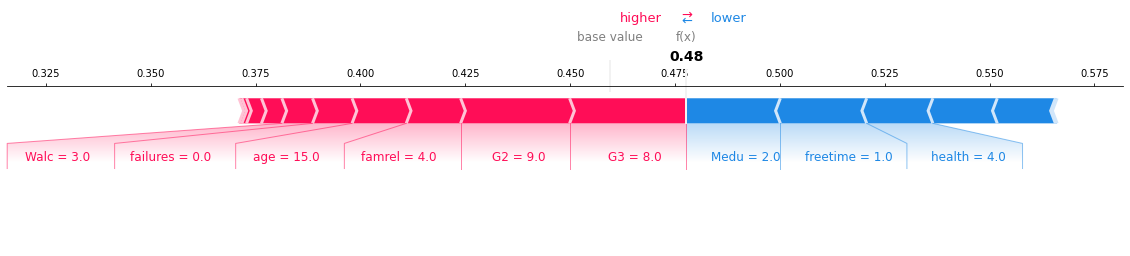

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[9,:], X_test[num_features].iloc[9,:], matplotlib=True)

- прогноз для этого наблюдения - 0.48. (порог 0.42, предсказание правильное)
- базовое значение это среднее предсказание или среднее значение (0.46)
- внизу показаны значения признаков для конкретного объекта тестовой выборки
- цвета: объекты, которые увеличивают прогноз, отображаются красным,
- а объекты, которые уменьшают, - синим цветом.
